In [96]:
!pip install yfinance
import yfinance
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
# Functions for RSI and Heikin Signal Generation

#Jerry
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

def rsi_signal_generation(rsi):
    # rsi should follow a normal distribution 
    # likelihood represents confidence 
    # more unlikely, more confident in the decision 
    zscore = (rsi - np.mean(rsi)) / np.std(rsi)
    p_values = stats.norm.sf(abs(zscore))
    confidence = 1 - p_values
    
    
    section = None
    sections = []
    for i in range(len(rsi)): 
        if rsi[i] < 30:
            section = 'oversold'
        elif rsi[i] > 70:
            section = 'overbought'
        else:
            section = None
        sections.append(section)

    trades = []
    trades.append(0)
    for i in range(1,len(sections)):
        trade = 0
        if sections[i-1] == 'oversold' and sections[i] == None:
            trade = 1
        if sections[i-1] == 'overbought' and sections[i] == None:
            trade = -1
        trades.append(trade)
    return trades, confidence


def heikin_ashi(data):
    
    df=data.copy()
    
    df.reset_index(inplace=True)
        
    #heikin ashi close
    df['HA close']=(df['Open']+df['Close']+df['High']+df['Low'])/4

    #initialize heikin ashi open
    df['HA open']=float(0)
    df['HA open'][0]=df['Open'][0]

    #heikin ashi open
    for n in range(1,len(df)):
        df.at[n,'HA open']=(df['HA open'][n-1]+df['HA close'][n-1])/2
        
    #heikin ashi high/low
    temp=pd.concat([df['HA open'],df['HA close'],df['Low'],df['High']],axis=1)
    df['HA high']=temp.apply(max,axis=1)
    df['HA low']=temp.apply(min,axis=1)

    del df['Adj Close']
    del df['Volume']
    
    return df


def signal_generation_jerry(df,method,stls):
        
    data=method(df)
    
    data['signals']=0


    data['cumsum']=0

    for n in range(1,len(data)):
        
        #long triggered
        if (data['HA open'][n]>data['HA close'][n] and data['HA open'][n]==data['HA high'][n] and
            np.abs(data['HA open'][n]-data['HA close'][n])>np.abs(data['HA open'][n-1]-data['HA close'][n-1]) and
            data['HA open'][n-1]>data['HA close'][n-1]):
            
            data.at[n,'signals']=1
            data['cumsum']=data['signals'].cumsum()


            #accumulate too many longs
            if data['cumsum'][n]>stls:
                data.at[n,'signals']=0
        
        #exit positions
        elif (data['HA open'][n]<data['HA close'][n] and data['HA open'][n]==data['HA low'][n] and 
        data['HA open'][n-1]<data['HA close'][n-1]):
            
            data.at[n,'signals']=-1
            data['cumsum']=data['signals'].cumsum()
        

            #clear all longs
            #if there are no long positions in my portfolio
            #ignore the exit signal
            if data['cumsum'][n]>0:
                data.at[n,'signals']=-1*(data['cumsum'][n-1])

            if data['cumsum'][n]<0:
                data.at[n,'signals']=0
                
    return data

In [98]:
# Functions for Pairs Trading signal generation

# Derek
def EG_method(X,Y):
    
    #step 1
    #estimate long run equilibrium
    model1=sm.OLS(Y,sm.add_constant(X)).fit()
    epsilon=model1.resid
    
    #check p value of augmented dickey fuller test
    #if p value is no larger than 5%, stationary test is passed
    if sm.tsa.stattools.adfuller(epsilon)[1]>0.05:
        return False,model1
    
    #take first order difference of X and Y plus the lagged residual from step 1
    X_dif=sm.add_constant(pd.concat([X.diff(),epsilon.shift(1)],axis=1).dropna())
    Y_dif=Y.diff().dropna()        
    
    #step 2
    #estimate error correction model
    model2=sm.OLS(Y_dif,X_dif).fit()
    
    #adjustment coefficient must be negative
    if list(model2.params)[-1]>0:
        return False,model1
    else:
        return True,model1

# Derek
def signal_generation(asset1,asset2,method,bandwidth=250):    
    
    signals=pd.DataFrame()
    # signals['asset1']=asset1['Close']
    # signals['asset2']=asset2['Close']
    signals['asset1']=np.log(asset1['Close'])
    signals['asset2']=np.log(asset2['Close'])
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan
        
        #cointegration starts
        #set the trigger conditions
        #this is no forward bias
        #just to minimize the calculation done in pandas
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:]))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stat
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)
        
        #as z stat cannot exceed both upper and lower bounds at the same time
        #the lines below hold
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i]:            
             signals.at[signals.index[i],'signals1']=1            
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i]:            
             signals.at[signals.index[i],'signals1']=-1
                
        prev_status=coint_status    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']

    return signals



In [99]:
# Functions for MACD Signal generation

#Brandon 
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df


def implement_macd_strategy(prices, df):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0
    data = get_macd(prices, 26, 12, 9)
    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal


In [100]:
# Download data from yfinance
stdate='2013-01-01'
eddate='2017-12-31'
ticker1='NVDA'
ticker2='AMD'

#extract data
asset1=yfinance.download(ticker1,start=stdate,end=eddate)
asset2=yfinance.download(ticker2,start=stdate,end=eddate)  
df=yfinance.download(ticker2, stdate, eddate)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Generate signals from each metric
macd_signal = implement_macd_strategy(df['Close'], df)[2]
rsi_signal = rsi_signal_generation(rsi(df))[0]
signals=signal_generation(asset1,asset2,EG_method)["signals2"]
stls=3
heikin_ashi_signal=signal_generation_jerry(df,heikin_ashi,stls)['signals']

In [102]:
# Some sanity checks on the generated signals 
print (f'MACD Length is {len(macd_signal)}')
print (f'RSI Length is {len(rsi_signal)}')
print (f'Pair trading Length is {len(signals)}')
print (f'Heikin Ashi Length is {len(heikin_ashi_signal)}')

def count_signals(signals):
  print(sum(np.abs(signals)))

count_signals(macd_signal)
count_signals(rsi_signal)
count_signals(signals)
count_signals(heikin_ashi_signal)

print (f'MACD frequency is {sum(np.abs(macd_signal))}')
print (f'RSI frequency is {sum(np.abs(rsi_signal))}')
print (f'Pair trading frequency is {sum(np.abs(signals))}')
print (f'Heikin Ashi frequency is {sum(np.abs(heikin_ashi_signal))}')

MACD Length is 1259
RSI Length is 1259
Pair trading Length is 1259
Heikin Ashi Length is 1259
106
37
283
246
MACD frequency is 106
RSI frequency is 37
Pair trading frequency is 283
Heikin Ashi frequency is 246


In [103]:
# Model hyperparameters
window_size = 10
initial_capital = 100000
trade_percent = 0.50

In [104]:
# Given all signals, perform the voting algorithm day by day and return the profit
def portfolio(asset, macd_signal, rsi_signal, pairs_signal, heikin_signal):
  returns = []
  amount_held = 0
  capital_available = initial_capital

  def liquidate(i, held):
    return asset.iloc[i]['Close'] * held
  
  def total_dollars(i, held):
    return capital_available + liquidate(i, held)

  def take_action(decision, capital_available, i, amount_held):
    if decision > 0: # buy
      capital_to_add = capital_available * trade_percent
      amount_held += capital_to_add / asset.iloc[i]["Close"]
      capital_available -= capital_to_add
      capital_available = max(0, capital_available)
      return capital_available, amount_held
    elif decision < 0: # sell
      stock_to_remove = amount_held * trade_percent
      capital_to_remove = stock_to_remove * asset.iloc[i]["Close"]
      amount_held -= stock_to_remove
      amount_held = max(0, amount_held)
      capital_available += capital_to_remove
      return capital_available, amount_held
    else: # hold
      return capital_available, amount_held
    
  for i in range(window_size, len(macd_signal)):
    macd_decision = sum(macd_signal[i-window_size:i])
    rsi_decision = sum(rsi_signal[i-window_size:i])
    pairs_decision = sum(pairs_signal[i-window_size:i])
    heikin_decision = sum(heikin_signal[i-window_size:i])

    final_decision = macd_decision + rsi_decision + pairs_decision + heikin_decision
    
    if final_decision > 0: # buy
      capital_to_add = capital_available * trade_percent
      amount_held += capital_to_add / asset.iloc[i]["Close"]
      capital_available -= capital_to_add
      capital_available = max(0, capital_available)
    elif final_decision < 0: # sell
      stock_to_remove = amount_held * trade_percent
      capital_to_remove = stock_to_remove * asset.iloc[i]["Close"]
      amount_held -= stock_to_remove
      amount_held = max(0, amount_held)
      capital_available += capital_to_remove
    else: # hold
      pass
    returns.append(total_dollars(i, amount_held))

    
  liquidate = asset.iloc[-1]['Close'] * amount_held
  print("End at:", capital_available + liquidate)
  print("Profit: ", capital_available + liquidate - initial_capital)
  return capital_available + liquidate - initial_capital, returns

our_profit, returns = portfolio(asset2, macd_signal, rsi_signal, signals, heikin_ashi_signal)




End at: 762374.7686775926
Profit:  662374.7686775926


In [105]:
# calculate profit from buying 100,000 of asset at start and selling at end of period (baseline)
def calculate_stock_profit(asset):
  amount_held = initial_capital / asset.iloc[0]['Close']
  return amount_held * asset.iloc[-1]['Close'] - initial_capital
amd_profit = calculate_stock_profit(asset2)
print("AMD Profit:", amd_profit)

AMD Profit: 306324.1047123103


In [106]:
print("Performance:", our_profit / amd_profit * 100.0, "%")

Performance: 216.23331578808452 %


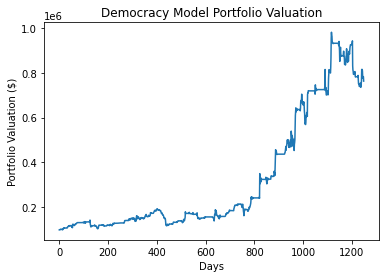

In [107]:
plt.title("Democracy Model Portfolio Valuation")
plt.ylabel("Portfolio Valuation ($)")
plt.xlabel("Days")
plt.plot(returns)

End at: 106324.73555300332
Profit:  6324.735553003324


Text(0.5, 1.0, 'MACD')

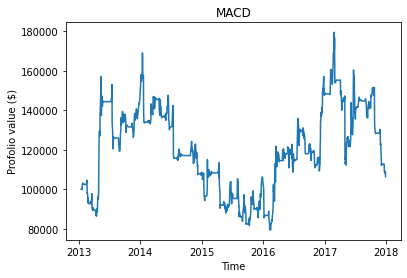

In [108]:
def portfolio(asset, macd_signal, rsi_signal, pairs_signal, heikin_signal, signal_to_pick):
  returns = []
  amount_held = 0
  capital_available = initial_capital
  def liquidate(i, held):
    return asset.iloc[i]['Close'] * held
  
  def total_dollars(i, held):
    return capital_available + liquidate(i, held)
    
  for i in range(window_size, len(macd_signal)):
    macd_decision = sum(macd_signal[i-window_size:i])
    rsi_decision = sum(rsi_signal[i-window_size:i])
    pairs_decision = sum(pairs_signal[i-window_size:i])
    heikin_decision = sum(heikin_signal[i-window_size:i])
    decisions = [macd_decision, rsi_decision, pairs_decision, heikin_decision] 
    final_decision = decisions[signal_to_pick]
    
    if final_decision > 0: # buy
      capital_to_add = capital_available * trade_percent
      amount_held += capital_to_add / asset.iloc[i]["Close"]
      capital_available -= capital_to_add
      capital_available = max(0, capital_available)
    elif final_decision < 0: # sell
      stock_to_remove = amount_held * trade_percent
      capital_to_remove = stock_to_remove * asset.iloc[i]["Close"]
      amount_held -= stock_to_remove
      amount_held = max(0, amount_held)
      capital_available += capital_to_remove
    else: # hold
      pass
    returns.append(total_dollars(i, amount_held))

    
  liquidate = asset.iloc[-1]['Close'] * amount_held
  print("End at:", capital_available + liquidate)
  print("Profit: ", capital_available + liquidate - initial_capital)
  return capital_available + liquidate - initial_capital, returns

our_profit_macd, returns_macd = portfolio(asset2, macd_signal, rsi_signal, signals, heikin_ashi_signal, 0)
plt.plot(asset2.index[10:], returns_macd)
plt.xlabel('Time')
plt.ylabel('Profolio value ($)')
plt.title('MACD')

End at: 144812.92884920162
Profit:  44812.92884920162


Text(0.5, 1.0, 'RSI')

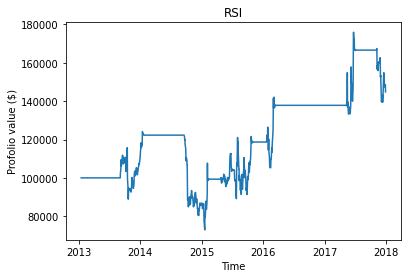

In [109]:
our_profit_rsi, returns_rsi = portfolio(asset2, macd_signal, rsi_signal, signals, heikin_ashi_signal, 1)
plt.plot(asset2.index[10:], returns_rsi)
plt.xlabel('Time')
plt.ylabel('Profolio value ($)')
plt.title('RSI')

End at: 454105.41280294256
Profit:  354105.41280294256


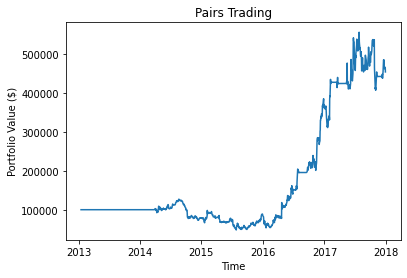

In [110]:
our_profit_pairs, returns_pairs = portfolio(asset2, macd_signal, rsi_signal, signals, heikin_ashi_signal, 2)
plt.title("Pairs Trading")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Time")
plt.plot(asset2.index[10:], returns_pairs)

End at: 497587.3315400226
Profit:  397587.3315400226


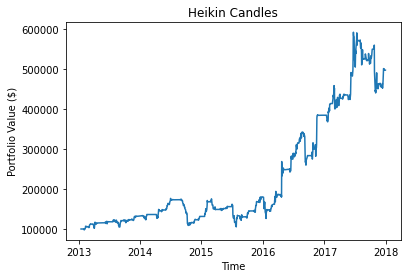

In [111]:
our_profit_heikin, returns_heikin = portfolio(asset2, macd_signal, rsi_signal, signals, heikin_ashi_signal, 3)
plt.title("Heikin Candles")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Time")
plt.plot(asset2.index[10:], returns_heikin)

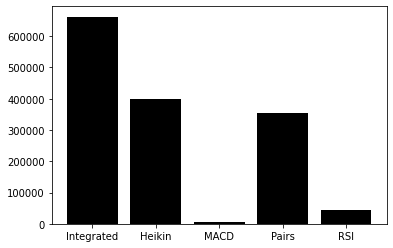

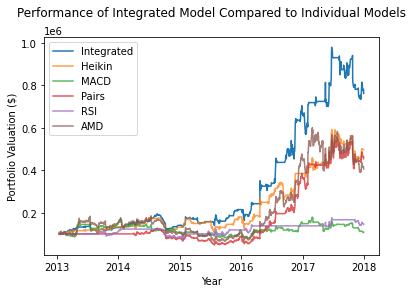

In [112]:
# comparison plots
total_profits = [our_profit, our_profit_heikin, our_profit_macd, our_profit_pairs, our_profit_rsi]
labels = ['Integrated', 'Heikin', 'MACD', 'Pairs', 'RSI']
total_returns = [returns, returns_heikin, returns_macd, returns_pairs, returns_rsi]
plt.bar(labels, total_profits, color='black')
x = asset2.index[10:]
plt.show()
for i in range(5):
  if labels[i] == 'Integrated':
    plt.plot(x, total_returns[i], label=labels[i])
  else: 
    plt.plot(x, total_returns[i], label=labels[i], alpha=0.75)
plt.title("Performance of Integrated Model Compared to Individual Models\n")
plt.xlabel("Year")
plt.ylabel("Portfolio Valuation ($)")
plt.plot(x, initial_capital / np.array(asset2['Close'])[0] * np.array(asset2['Close'])[10:], label='AMD', alpha=0.75)
plt.legend()